# Analysis of experimental data

This notebook is about the reproduction of the figures presented in the paper

In [18]:
import sys
import os
import warnings
import pandas as pd
sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

from torchpgm import * 
from utils import *
from config import *
from scipy.stats import *
from scipy.ndimage import *
from tqdm import tqdm_notebook

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.multioutput import *
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, SparsePCA


import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

def mcherry_threshold(x):
    if x < 0.2:
        return 0
    if x < 0.5:
        return 1
    if x < 0.8:
        return 2
    return 3

batch = 1
colors = ["red","darkorange","gold", "green", "gray", "gray"]
batch_color = ["gray",  "orange", "purple"]


## Loading the data

In [9]:
df = pd.read_csv(f"{DATA}/variants/ml-designed-pid.csv")
name = df[df.batch  >= batch]["id"].values

fx_intenergy = df[df.batch  >= batch]["fx_intenergy"].apply(lambda x : float(x)).values
fx_ddg = df[df.batch >= batch]["fx_ddg"].apply(lambda x : float(x)).values

e_rbm = df[df.batch  >= batch]["e_rbm"].apply(lambda x : float(x)).values
c_rbm  = df[df.batch  >= batch]["c_rbm"].apply(lambda x : float(x)).values
af2_rmsd = df[df.batch  >= batch]["af2_rmsd"].apply(lambda x : float(x)).values
af2_tmscore = df[df.batch  >= batch]["af2_tmscore"].apply(lambda x : float(x)).values
af2_plddt = df[df.batch  >= batch]["af2_plddt"].apply(lambda x : float(x)).values
af2_ptmscore = df[df.batch  >= batch]["af2_ptmscore"].apply(lambda x : float(x)).values
diff_spycas9 = df[df.batch >= batch]["diff_spycas9"].apply(lambda x : float(x)).values
batch_number = df[df.batch >= batch]["batch"].apply(lambda x:int(x)).values
functionality = df[df.batch  >= batch]["norm_repression"].apply(lambda x:colors[mcherry_threshold(x)]).values
functionality_number = df[df.batch  >= batch]["norm_repression"].apply(lambda x:mcherry_threshold(x)).values

norm_repression = df[df.batch >= batch]["norm_repression"].values
norm_repression_std = df[df.batch >= batch]["norm_repression_std"].values 

In [6]:
Npam = 5
Nh = 200
folder = f"{DATA}/vink"
model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}_best"
best_epoch = 90

train_dataset_labelled = RBMDataWithPAM(f"{DATA}/vink/data.pt", Npam, subset = "train_labelled")
val_dataset_labelled = RBMDataWithPAM(f"{DATA}/vink/data.pt", Npam, subset = "val_labelled")
val_loader_labelled = DataLoader(val_dataset_labelled, batch_size = 1000, shuffle = False)

q_pi, N_pi = train_dataset_labelled[0][0].size()

pi = OneHotLayer(None, N=N_pi, q=q_pi, name="pi")
h = GaussianLayer(N=Nh, name="hidden")
classifier = PAM_classifier(Nh, Npam * 4, dropout = 0.)
E = [(pi.name, h.name)]
E.sort()

model_rbm_ssl = PI_RBM_SSL(classifier, layers= {pi.name: pi, h.name: h}, edges=E, name = "")
model_rbm_ssl.load(f"{folder}/weights/{model_full_name}_{best_epoch}.h5")
model_rbm_ssl = model_rbm_ssl.to("cuda")
model_rbm_ssl.ais()

c = model_rbm_ssl.classifier(model_rbm_ssl.edges["pi -> hidden"](X_labelled.cuda(), sample=False)).cpu()[:, [1,4+3,8+3,12+3]].sigmoid().log().sum(1).detach().numpy()[23:]

e_rbm = -(model_rbm_ssl({"pi":X_labelled.cuda()})/736 - model_rbm_ssl.Z).cpu().detach().numpy()
e_rbm = e_rbm[23:]

spearmanr(mcherry, e_rbm)


Available :  pi_seq L labelled subset weights x y
Available :  pi_seq L labelled subset weights x y


SignificanceResult(statistic=-0.7145875251509054, pvalue=2.591373061939093e-12)

## Distribution of activity

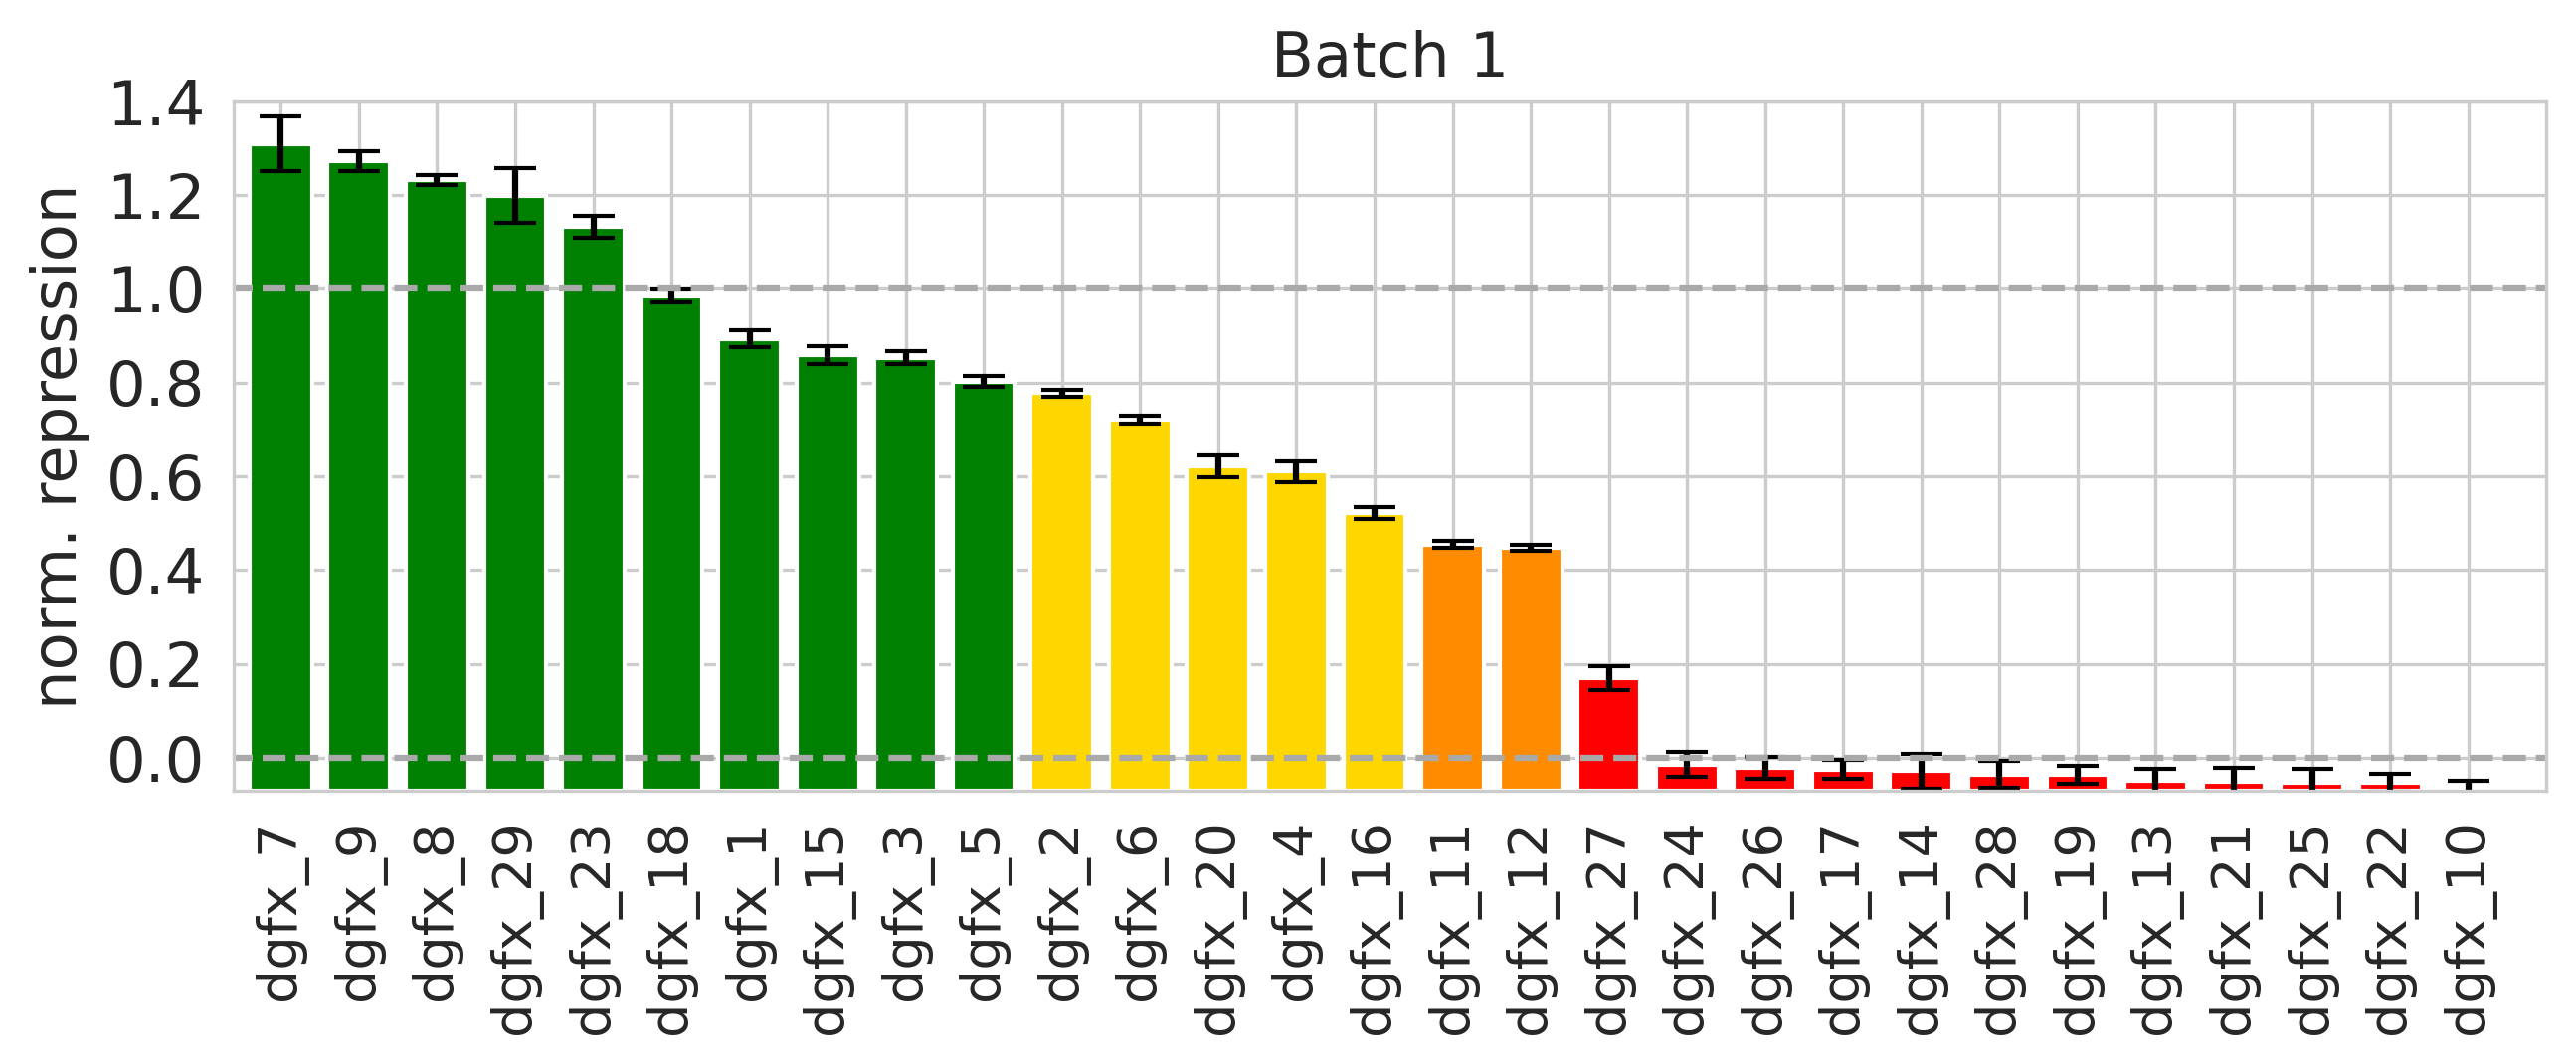

In [16]:
plt.figure(figsize=(10,3))
plt.bar(name[batch_number==1][(-norm_repression)[batch_number==1].argsort()], sorted(norm_repression[batch_number==1]+0.07)[::-1], 
        color = functionality[batch_number==1][(-norm_repression)[batch_number==1].argsort()], 
        bottom = -0.07, 
       yerr = 2*norm_repression_std[batch_number==1][(-norm_repression)[batch_number==1].argsort()], ecolor = "black", capsize=5)
plt.plot([-10,100],[1,1], "--", c="darkgray")
plt.plot([-10,100],[0,0], "--", c="darkgray")
plt.xticks(fontsize = 13,rotation = 90)
plt.yticks(fontsize = 15)
plt.xlim(-0.6,sum(batch_number==1))
plt.ylim(-0.07,1.4)
plt.title("Batch 1", fontsize = 15)
plt.ylabel("norm. repression", fontsize = 15)
plt.savefig("img.svg", format="svg", dpi=1200)
plt.show()

In [7]:
norm_repression_std[57] = 0
name[57] = "#dgfx_60"

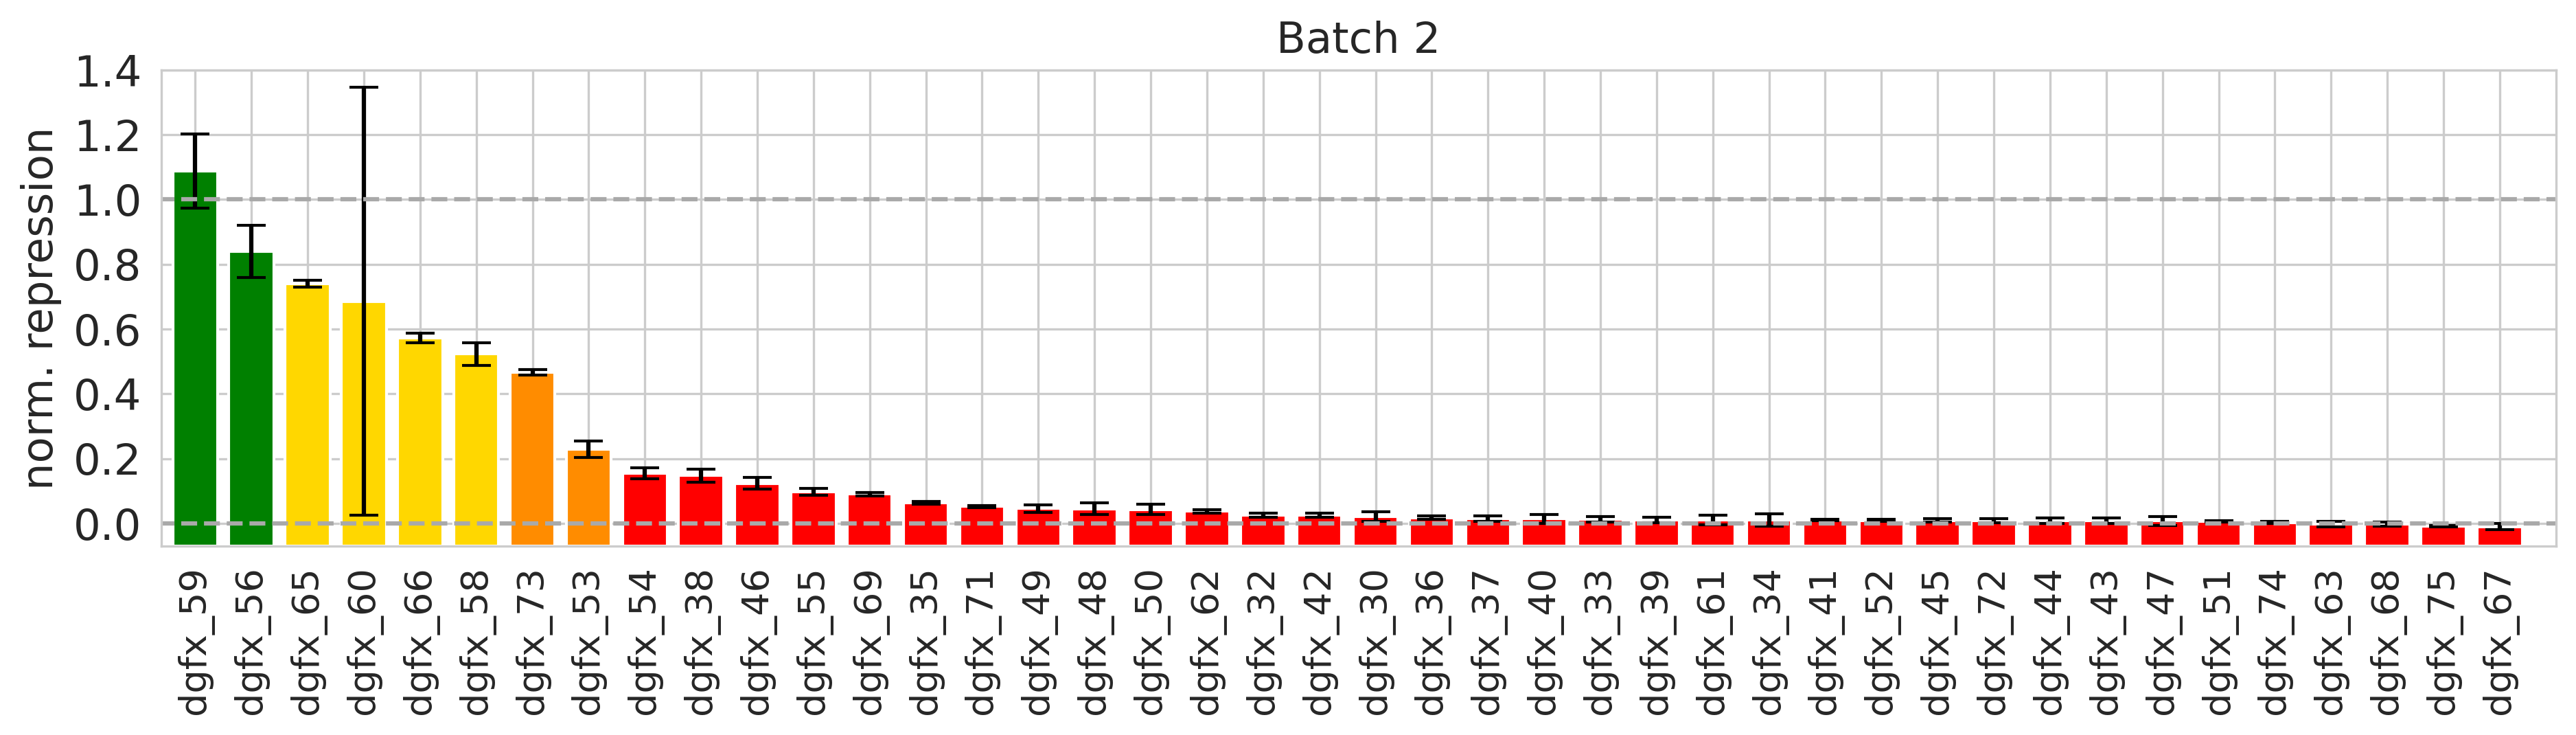

In [14]:
plt.figure(figsize=(15,3))
plt.bar(name[batch_number==2][(-norm_repression)[batch_number==2].argsort()], 
        sorted(norm_repression[batch_number==2]+0.07)[::-1], 
        color = functionality[batch_number==2][(-norm_repression)[batch_number==2].argsort()], 
        bottom = -0.07, 
       yerr = 2*norm_repression_std[batch_number==2][(-norm_repression)[batch_number==2].argsort()], 
        ecolor = "black", capsize=5)
plt.plot([-10,100],[1,1], "--", c="darkgray")
plt.plot([-10,100],[0,0], "--", c="darkgray")
plt.xticks(fontsize = 13,rotation = 90)
plt.yticks(fontsize = 15)
plt.xlim(-0.6,sum(batch_number==2))
plt.ylim(-0.07,1.4)
plt.ylabel("norm. repression", fontsize = 15)
plt.title("Batch 2", fontsize = 15)
plt.show()

## Correlation between activity and scores and between scores

Here we list the scores we want to analyse

In [21]:
x = np.array([e_rbm, c_rbm, fx_ddg, fx_intenergy, af2_rmsd, af2_tmscore, af2_plddt])
labels = ["$E_{\mathrm{RBM}}$", "Class.", "$\Delta\Delta G$", "Int. Energy", "RMSD", "TM-Score", "pLDDT"]
labels_long = ["$E_{\mathrm{RBM}}$ ($\gamma = 5$)", "Classifier  ($\gamma = 5$)", "$\Delta\Delta G$ (FoldX)", "Interaction Energy (FoldX)","RMSD (AlphaFold2)","TM-score (AlphaFold2)", "pLDDT (AlphaFold2)"]

regime = [np.where(np.array(list(vec)))[0] for vec in product([0,1], [0,1], [0,1], [0,1])][1:]
names = [", ".join([labels[i] for i in list(idx)]) for idx in regime]
regime, names 

([array([3]),
  array([2]),
  array([2, 3]),
  array([1]),
  array([1, 3]),
  array([1, 2]),
  array([1, 2, 3]),
  array([0]),
  array([0, 3]),
  array([0, 2]),
  array([0, 2, 3]),
  array([0, 1]),
  array([0, 1, 3]),
  array([0, 1, 2]),
  array([0, 1, 2, 3])],
 ['Int. Energy',
  '$\\Delta\\Delta G$',
  '$\\Delta\\Delta G$, Int. Energy',
  'Class.',
  'Class., Int. Energy',
  'Class., $\\Delta\\Delta G$',
  'Class., $\\Delta\\Delta G$, Int. Energy',
  '$E_{\\mathrm{RBM}}$',
  '$E_{\\mathrm{RBM}}$, Int. Energy',
  '$E_{\\mathrm{RBM}}$, $\\Delta\\Delta G$',
  '$E_{\\mathrm{RBM}}$, $\\Delta\\Delta G$, Int. Energy',
  '$E_{\\mathrm{RBM}}$, Class.',
  '$E_{\\mathrm{RBM}}$, Class., Int. Energy',
  '$E_{\\mathrm{RBM}}$, Class., $\\Delta\\Delta G$',
  '$E_{\\mathrm{RBM}}$, Class., $\\Delta\\Delta G$, Int. Energy'])

In [22]:
y = (norm_repression > 0.5)
X = x.T
auc = 0
n_tries = 1000

auc = {k:[] for k in names}
for _ in tqdm_notebook(range(n_tries)):
    kf = KFold(2, shuffle =True)
    for train_idx, test_idx in kf.split(y, ):
        train_idx = np.array(range(29))
        test_idx = np.array(range(29, 71))
        for k, r in zip(names, regime):
            X_train, y_train = X[train_idx][:,r], y[train_idx]
            X_test, y_test = X[test_idx][:,r], y[test_idx]
            if len(r)==1:
                X_train = X_train.reshape(-1, 1)
                X_test = X_test.reshape(-1, 1)
            scaler = StandardScaler().fit(X_train)
            clf = LogisticRegression().fit(scaler.transform(X_train), y_train, )
            auc[k].append(roc_auc_score(y_test, clf.predict_proba(scaler.transform(X_test))[:,1]))        

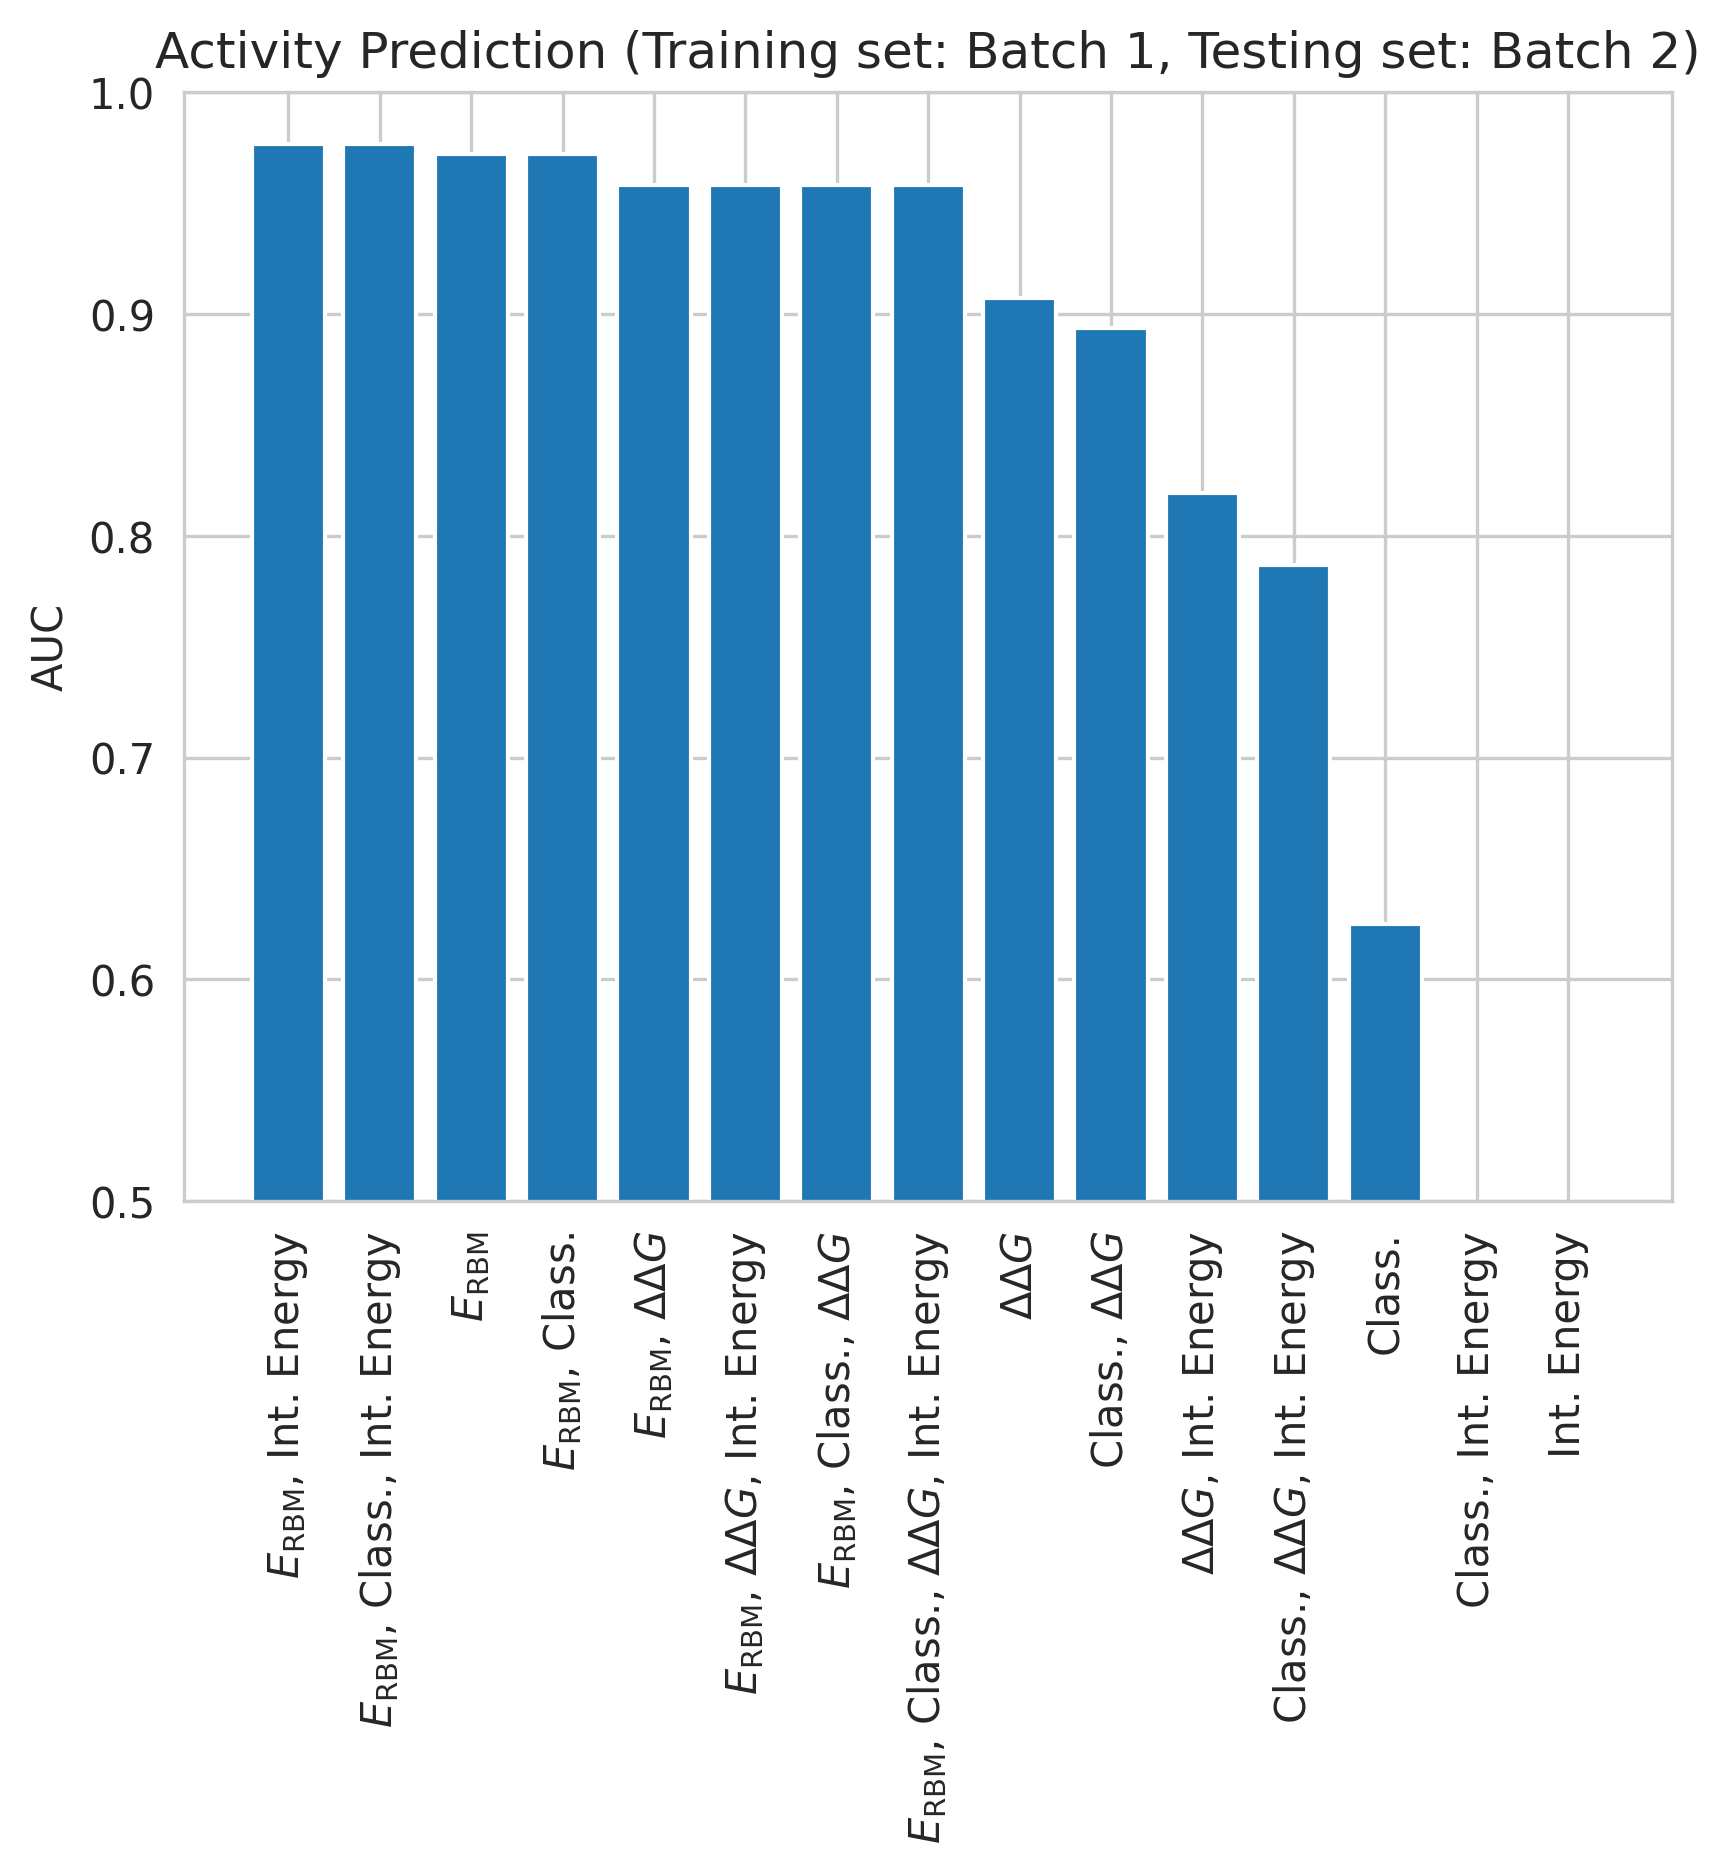

In [23]:
auc_mean = {k: np.mean(np.array(v)) for k, v in auc.items()}
auc_error = {k: np.std(np.array(v)) for k, v in auc.items()}

# Sort the auc_mean dictionary in descending order and update auc_error accordingly
sorted_keys = sorted(auc_mean, key=auc_mean.get, reverse=True)
sorted_auc_mean = {key: auc_mean[key] for key in sorted_keys}
sorted_auc_error = {key: auc_error[key] for key in sorted_keys}

# Create the bar plot
plt.bar(sorted_auc_mean.keys(), sorted_auc_mean.values(), yerr=[sorted_auc_error[key] for key in sorted_keys])
plt.ylabel("AUC")
plt.title("Activity Prediction (Training set: Batch 1, Testing set: Batch 2)")
plt.ylim(0.5, 1)
plt.xticks(rotation=90)

# Show the plot
plt.show()

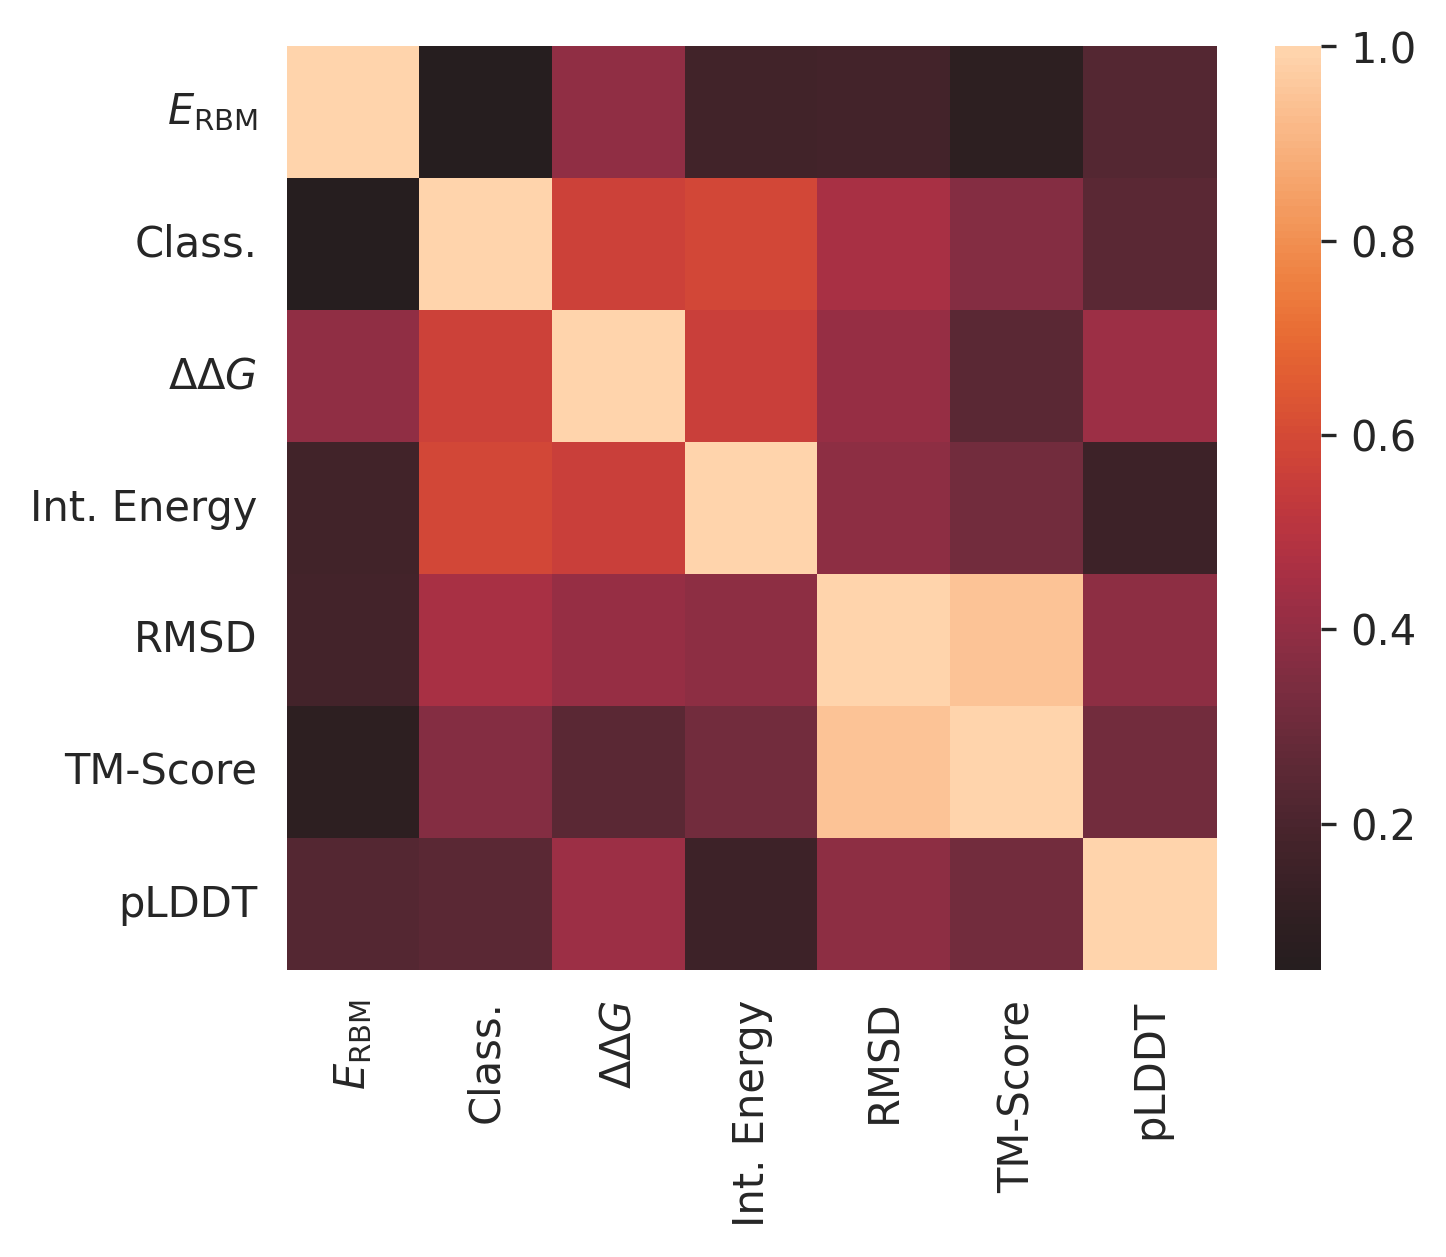

In [24]:
plt.figure(figsize = (5,4))
sns.heatmap(np.abs(np.corrcoef(x)), xticklabels = labels,  yticklabels = labels, center=0)
plt.yticks(rotation = 0)
plt.show()

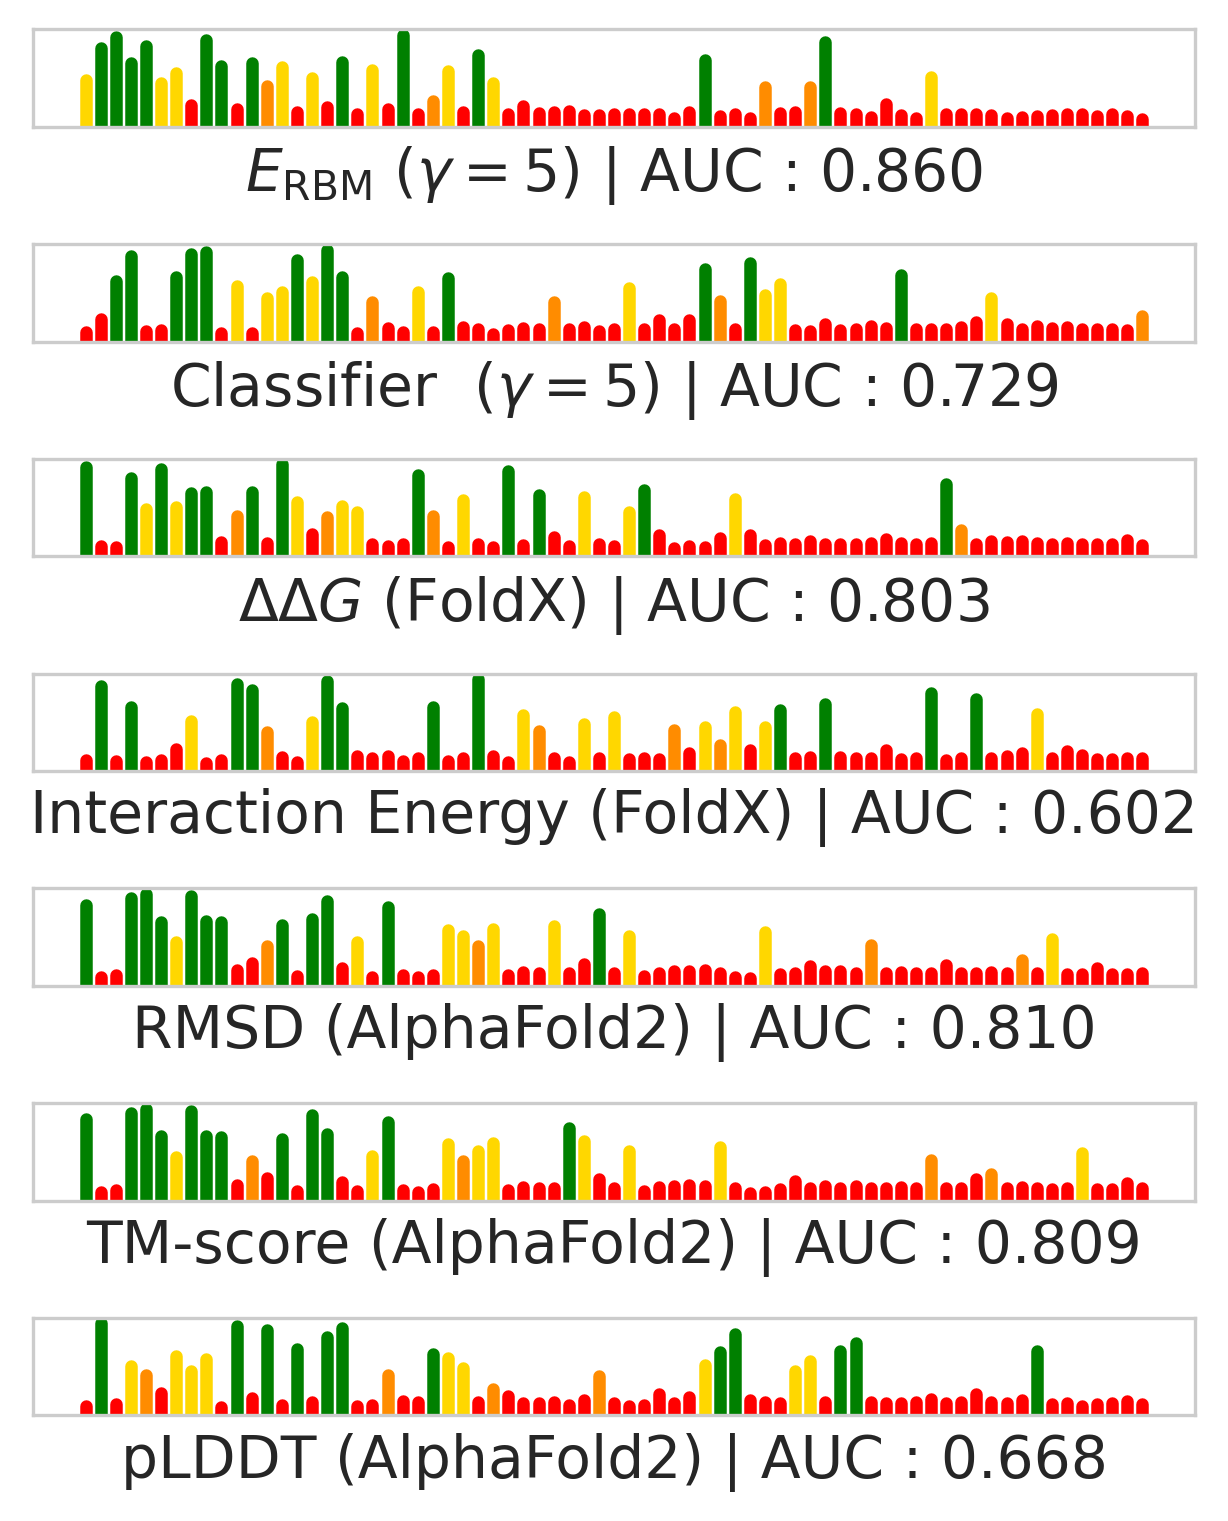

In [25]:
colors = ["red","darkorange","gold","green"]

plt.figure(figsize = (5,6))
plt.subplots_adjust( 
                    hspace=1.2)

for i, (x_, lab) in enumerate(zip(x, labels_long)):
    if spearmanr(norm_repression, x_)[0]>0:
        x_ = -x_
    plt.subplot(len(labels), 1, i+1)
    for x__, col, bar in zip(x_.argsort().argsort(), functionality, norm_repression):
        plt.plot([x__,x__], [-.2,bar], c = col, linewidth=3, )
    plt.xlabel(f"{lab} | AUC : {roc_auc_score(np.where(norm_repression>0.5,1,0), -x_):.3f}",size=14,)

    plt.yticks([])
    plt.xticks([])
    plt.ylim(-0.2,1.4)
    plt.xticks(size=12)
plt.show()

## Correlation between activity and position of mutations

In [ ]:
from Bio import PDB

def extract_dna_coordinates(structure, ):
    """
    Extract atomic coordinates based on chain type.
    chain_type can be 'protein' or 'dna'
    """
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if chain.id == 'C' or chain.id == 'D':
                    # The condition here assumes that DNA residues have different IDs from protein and water
                    for atom in residue:
                        coords.append(atom.coord)
    return coords


def minimum_distance(point, coords):
    """
    Calculate the minimum Euclidean distance between a point and a set of coordinates.
    """
    return min(((point - coord) ** 2).sum() ** 0.5 for coord in coords)


In [ ]:
complex_pdb_file_path = f"{DATA}/in_complex.pdb"

# Load PDB file
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("complex", complex_pdb_file_path)

# Extract atomic coordinates for protein and DNA
dna_coords = extract_dna_coordinates(structure)

# Determine residues at DNA interface
interface_residues = []
min_distance = []
threshold = 5.0  # Ångstroms

for model in structure:
    for chain in model:
        if chain.id != 'A':
            continue
        for residue in chain:
            d = 1e5
            if residue.id[0] == ' ':  # Only consider standard residues, not HETATM
                for atom in residue:
                    d_ = minimum_distance(atom.coord, dna_coords)
                    d = min(d, d_)
                min_distance.append(d)
                if d < threshold:
                    interface_residues.append(residue.id[1] - 1102)

print(f"Residues at DNA interface: {interface_residues}")
alascan_path = f"in_complex_AS.fxout"

critical_for_stability_residues = []
threshold = 1.  # kcal/mol
with open(alascan_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        parts = line.split()
        residue = parts[0]
        position = int(parts[1])
        energy_change = float(parts[-1])

        if energy_change > threshold:
            critical_for_stability_residues.append(position - 1102)
critical_for_stability_residues = set(critical_for_stability_residues)
df = pd.read_excel(f"{DATA}/ML-designed PID.xlsx")

wt = df[df.batch == 0].iloc[0].seq
sequences = list(df[df.batch >= batch].seq)

mutations = []
nb_mutations = []
nb_mutations_per_functionality = [[], [], [], []]
nb_mutations_at_interface = []
nb_mutations_at_interface_per_functionality = [[], [], [], []]
nb_mutations_at_stability = []
nb_mutations_at_stability_per_functionality = [[], [], [], []]
distance_mutations_at_interface = []
for functionality_number_, seq in zip(functionality_number, sequences):
    mutations.append(set([i for i in range(len(wt)) if wt[i] != seq[i]]))
    nb_mutations.append(len(mutations[-1]))
    nb_mutations_at_interface.append(len(mutations[-1].intersection(interface_residues)))
    nb_mutations_at_stability.append(len(mutations[-1].intersection(critical_for_stability_residues)))
    nb_mutations_per_functionality[functionality_number_].append(nb_mutations[-1])
    nb_mutations_at_interface_per_functionality[functionality_number_].append(nb_mutations_at_interface[-1])
    nb_mutations_at_stability_per_functionality[functionality_number_].append(nb_mutations_at_stability[-1])
    distance_mutations_at_interface.append([min_distance[i] for i in mutations[-1] for j in interface_residues])

n = len(critical_for_stability_residues)
for x, c in zip(nb_mutations_at_stability_per_functionality[::-1], colors[:4][::-1]):
    plt.hist([x_ / n for x_ in x], bins=np.arange(-.0, 1.05, 0.025), color=c)
    plt.xlabel(f"Share of stabilizing residues mutated ({n} residues).")
    plt.ylabel("Number of sequences")
    plt.xlim(0, 0.2)
plt.show()

## Effect of $\gamma$ on accuracy

In [152]:
gammas = sorted(gammas)
selected_gammas = gammas[260:542]

spears = []
es = []
preds = []
cs = []
X_train = torch.stack(train_dataset_labelled.x_d,0).detach().float()
Y_train = train_dataset_labelled.y
X_test = torch.stack(val_dataset_labelled.x_d,0).detach().float()
Y_test = val_dataset_labelled.y

model_rbm_ssl = model_rbm_ssl.to("cpu")
with torch.no_grad():
    for gamma in tqdm_notebook(selected_gammas):
        model_full_name = f"rbmssl_pid_h{Nh}_npam{Npam}_gamma{gamma}"
        model_rbm_ssl.load(f"{DATA}/vink/weights/{model_full_name}_90.h5")
        model_rbm_ssl.eval()
        
        h_train = model_rbm_ssl.edges["pi -> hidden"](X_train, sample = False)
        h_test = model_rbm_ssl.edges["pi -> hidden"](X_test, sample = False)        
        c = model_rbm_ssl.classifier(h_test)

        clf = MultiOutputClassifier(LogisticRegression()).fit(h_train, Y_train)
        pred_reg = np.array([x for x in clf.predict_proba(h_test)])
        preds.append([np.mean([roc_auc_score(y,pred) for y, pred in zip(Y_test.T, c.T) if ((sum(y)>0) and (sum(1-y)>0))]), 
                      np.mean([roc_auc_score(y,pred) for y, pred in zip(Y_test.T, pred_reg[:,:,1]) if ((sum(y)>0) and (sum(1-y)>0))])])
        
        
        e_rbm = model_rbm_ssl({"pi":X_labelled})
        spears.append((roc_auc_score((mcherry>0.8),e_rbm[23:]), spearmanr(mcherry, e_rbm[23:])[0]))
        
        h_expe =  model_rbm_ssl.edges["pi -> hidden"](X_labelled, sample = False)
        loo = LeaveOneOut()
        expe_preds = np.zeros(len(h_expe[23:]))
        for train_index, test_index in loo.split(h_expe[23:]):
            clf = LogisticRegression().fit(h_expe[23:][train_index], (mcherry[train_index]>0.6))
            expe_preds[test_index] = clf.predict_proba(h_expe[test_index])[:,1]
        spears.append((roc_auc_score((mcherry>0.8),-expe_preds), spearmanr(mcherry, e_rbm[23:])[0]))


  0%|          | 0/282 [00:00<?, ?it/s]

KeyboardInterrupt: 

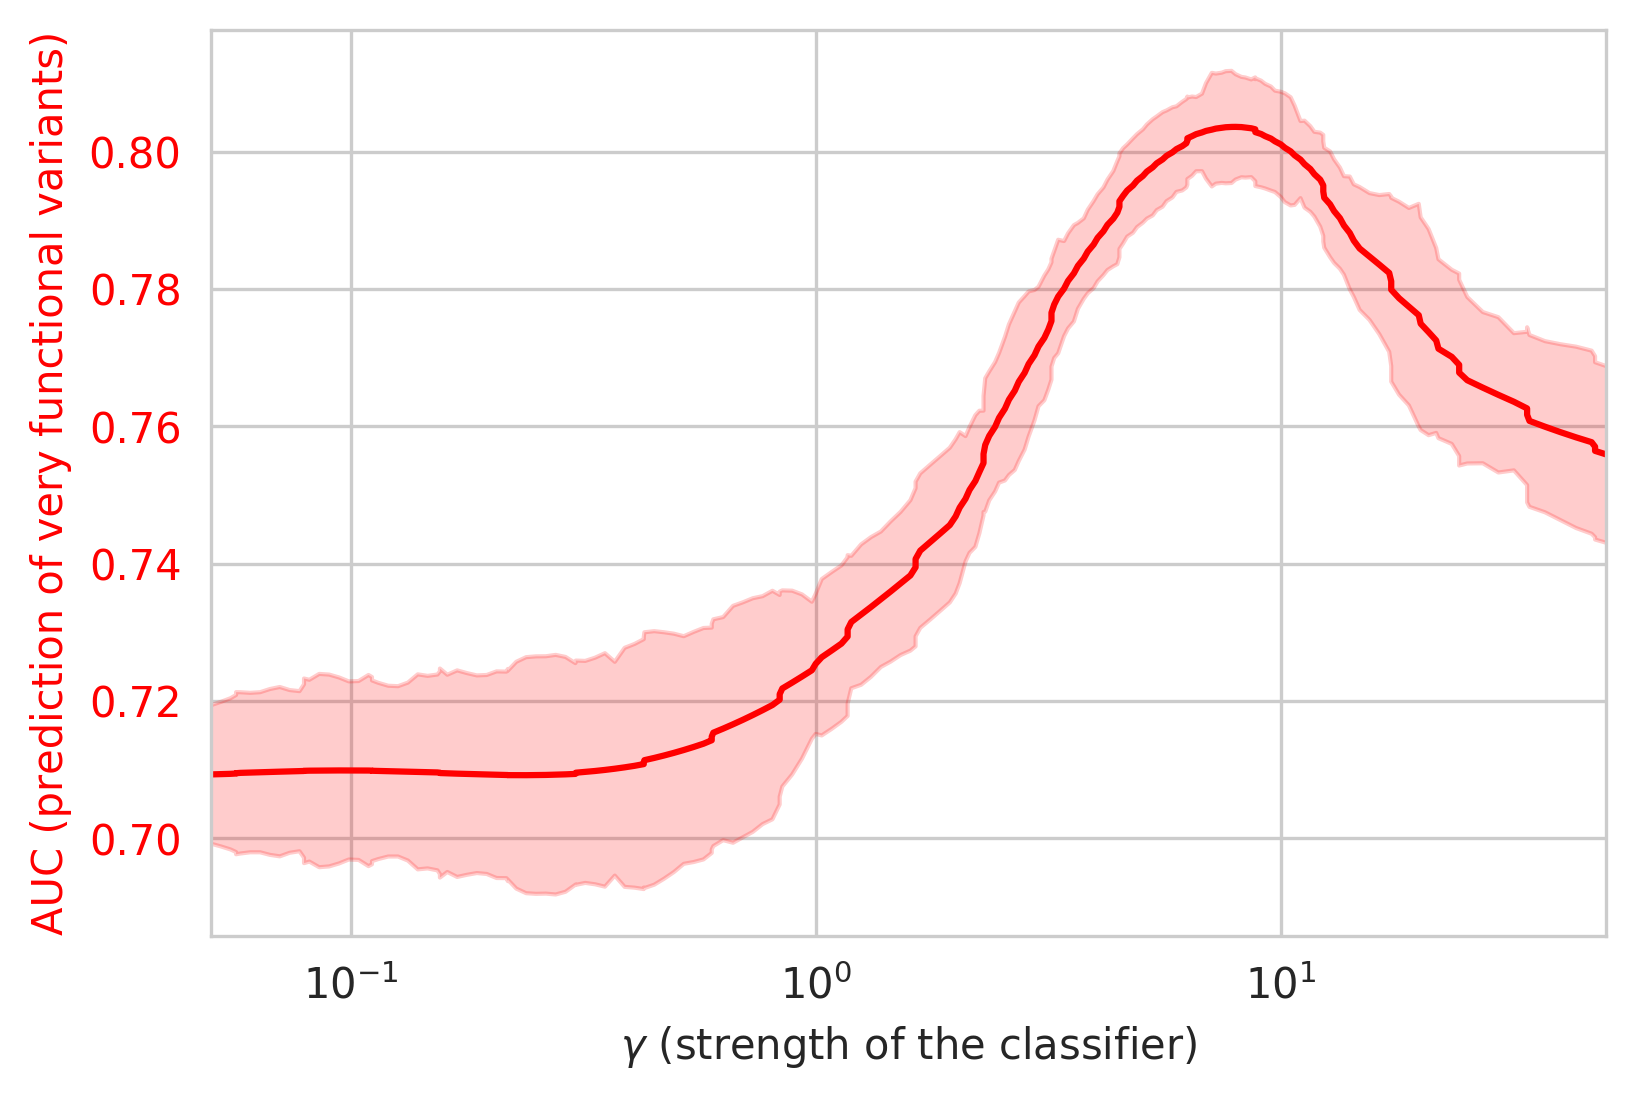

In [137]:
n = 20

fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax]

# And finally we get to plot things...
colors = ('Red', 'Blue', 'Green')

#values = np.array([x[0] for x in preds])
values = np.array([x[0] for i, x in enumerate(spears) if i%2==0])
fvalues = gaussian_filter1d(values[1:],n, mode="nearest")
errors = np.array([np.std(values[i:i+n]) for i in range(1,len(values)-n)])/2
axes[0].plot(selected_gammas[1:], gaussian_filter1d(values[1:],n,  mode="nearest"), c="red")
axes[0].fill_between(selected_gammas[n//2+1:-n//2], fvalues[n//2:-n//2]-errors, fvalues[n//2:-n//2]+errors, color="red", alpha = 0.2)
axes[0].set_ylabel('AUC (prediction of very functional variants)' , color=colors[0])
axes[0].tick_params(axis='y', colors=colors[0])

plt.xscale("log")
plt.xlim(5e-2,50)
axes[0].set_xlabel("$\gamma$ (strength of the classifier)")
#plt.legend(["Spearmanr", "Classifier", "Classifier Retrained"])
plt.show()


In [29]:
from scipy.ndimage import *

n = 20

fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [None, 
        ax]

# Make some space on the right side for the extra y-axis.
#fig.subplots_adjust(right=0.75)


values = np.array([x[0] for x in spears])
fvalues = gaussian_filter1d(values[1:],n, mode="nearest")
errors = np.array([np.std(values[i:i+n]) for i in range(1,len(values)-n)])
axes[1].plot(gammas[1:], gaussian_filter1d(values[1:],n,  mode="nearest"), c="red")
axes[1].fill_between(gammas[n//2+1:-n//2], fvalues[n//2:-n//2]-errors, fvalues[n//2:-n//2]+errors, color="red", alpha = 0.2)
axes[1].set_ylabel('Spearmanr (experimental)' , color=colors[0])
axes[1].tick_params(axis='y', colors=colors[0])
axes[1].set_yticks(np.arange(0.56,0.7,0.02))
axes[1].set_ylim(0.56,0.7)




#values = np.array([x[1] for x in preds])
#axes[1].plot(gammas[n-1:], [np.mean([x for j,x in enumerate(values[i:i+n])])  for i in range(len(values[:])-n+1)], 
             #color=colors[2])
#axes[1].plot(gammas[n-1:],values[n-1:], color=colors[2], alpha=0.2)


plt.xscale("log")
plt.xlim(1e-1,50)
axes[0].set_xlabel("Gamma (strength of the classifier)")
#plt.legend(["Spearmanr", "Classifier", "Classifier Retrained"])
plt.show()


AttributeError: 'NoneType' object has no attribute 'set_xlabel'

In [103]:
thr = [np.inf, -.12, -.135,-.15]
X = fx_dna
share_of_active_samples=[]
table = """
\\begin{table}[!htb]
\\begin{tabular}{ccccc|}
\\hline
\\multicolumn{1}{|c}{} & $\\mathbf{E_{RBM} 
\\infty}$ & $\\mathbf{E_{RBM} < -0.12}$ & $\\mathbf{E_{RBM} < -0.135}$ & $\\mathbf{E_{RBM} < -0.15}$\\\\ """
for i, (func, name) in enumerate(zip([.8], ['marginally functional or more', 'functional or more', 'very functional'])):
    y = mcherry>=func
    for x in [np.inf, 90,85,80,78]:
        table += "\\multicolumn{1}{|c}{${\\mathbf{fx < " + str(x) + "}}$}"
        for j, e in enumerate(thr):
            idx = np.where((X<x)&(e_rbm<=e))[0]
            share_of_active_samples.append(sum(y[idx])/len(idx))
            table += f" & {sum(y[idx])/len(idx):.3f} [{sum(y[idx])}/{len(idx)}]"
        table += "\\\\\n"
table += """\\hline\n\\end{tabular}\n
\\end{table}""" 

print(table)

TypeError: unsupported operand type(s) for &: 'numpy.ndarray' and 'Tensor'